In [1]:
from fenics import *
from dolfin_adjoint import *
import pygmsh_mesh_functions
from pygmsh_mesh_functions import *
import meshio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import skimage.io
from skimage.measure import find_contours, subdivide_polygon, approximate_polygon

## load image 

In [3]:
img_path = './GRF.png'
img = skimage.io.imread(img_path)
print('data_max = {}'.format(np.max(img)))
print('data_min = {}'.format(np.min(img)))
imsize = img.shape

data_max = 255
data_min = 0


In [4]:
imsize[0]

100

In [5]:
markers = np.zeros_like(img)
markers[img < 128] = 0
markers[img > 128] = 1

contours_list = find_contours(img, 128)

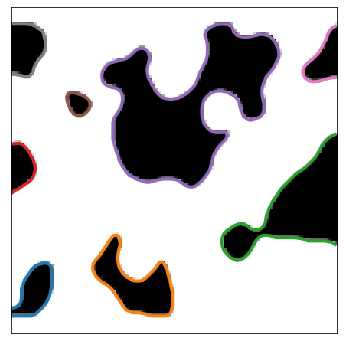

In [13]:
# x = np.arange(imsize[0])
# y = np.arange(imsize[1])

# xx, yy = np.meshgrid(x,y)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(img, cmap=plt.cm.gray, origin='lower')
# ax.pcolor(xx,yy,img)

for i in range(len(contours_list)):
    ax.plot(np.array(contours_list[i].T)[1],np.array(contours_list[i].T)[0],'-',linewidth=3)
    
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)

In [7]:
def hole_polygon(domain, polygon, scale, tol=1e-2):
    if np.array_equal(polygon[-1],polygon[0]):
        polygon = polygon[:-1]
    
    polygon
    tool = add_polygon(polygon*scale)
    domain = subtract(domain, tool)

Info    : Running '/home/fenics/.local/bin/gmsh -3 /tmp/tmpxzmxycdr.geo -format msh -bin -o /tmp/tmpnj20_axi.msh' [Gmsh 4.9.5, 1 node, max. 1 thread]
Info    : Started on Tue May 17 02:59:49 2022
Info    : Reading '/tmp/tmpxzmxycdr.geo'...
Info    : Done reading '/tmp/tmpxzmxycdr.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1655 (Line)
Info    : [ 10%] Meshing curve 1656 (Line)
Info    : [ 10%] Meshing curve 1657 (Line)
Info    : [ 10%] Meshing curve 1658 (Line)
Info    : [ 10%] Meshing curve 1659 (Line)
Info    : [ 10%] Meshing curve 1660 (Line)
Info    : [ 10%] Meshing curve 1661 (Line)
Info    : [ 10%] Meshing curve 1662 (Line)
Info    : [ 10%] Meshing curve 1663 (Line)
Info    : [ 10%] Meshing curve 1664 (Line)
Info    : [ 10%] Meshing curve 1665 (Line)
Info    : [ 10%] Meshing curve 1666 (Line)
Info    : [ 10%] Meshing curve 1667 (Line)
Info    : [ 10%] Meshing curve 1668 (Line)
Info    : [ 10%] Meshing curve 1669 (Line)
Info    : [ 10%] Meshing curve 1670 (Line)
In

Info    : Done meshing 2D (Wall 0.202422s, CPU 0.20242s)
Your choice of mesh element sizes will likely produce a very
large mesh. Do you really want to continue?

(To disable this warning in the future, select `Enable expert mode'
in the option dialog.)

0=[Cancel] 1=[Continue] (default=1): Info    : Meshing 3D...
Info    : Done meshing 3D (Wall 3.49e-05s, CPU 3.5e-05s)
Info    : 6498 nodes 13430 elements
Info    : Writing '/tmp/tmpnj20_axi.msh'...
Info    : Done writing '/tmp/tmpnj20_axi.msh'
Info    : Stopped on Tue May 17 02:59:49 2022 (From start: Wall 0.492378s, CPU 0.62614s)


6498

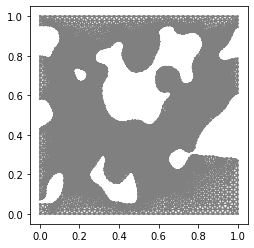

In [9]:
reset_geometry()

Lx = 1
Ly = 1

meshsize_min = 0.025
meshsize_max = 0.025

pygmsh_mesh_functions.hmeshmin = meshsize_min
pygmsh_mesh_functions.hmeshmax = meshsize_max

domain = add_polygon([(0, 0), (Lx, 0), (Lx, Ly), (0, Ly)])
X0 = np.array([0, 0])

#OPERATIONS ON DOMAIN
for i in range(len(contours_list)):
    polygon = np.flip(contours_list[i],axis=1)
    polygon_subdivide = subdivide_polygon(polygon, degree=2, preserve_ends=True)
    polygon_approx = approximate_polygon(polygon_subdivide,0.05)
    
    hole_polygon(domain, polygon_approx, 1/(imsize[0]-1))


#CREATE AND STORE MESH
sample_name = "test_binary_image.xdmf"
out_dir = pathlib.Path("output_files")
out_dir.mkdir(parents=True, exist_ok=True)
mesh = create_fenics_mesh(mesh_path = out_dir / sample_name, verbose=True)
cell_type = mesh.cell_name()
with create_XDMFFile(out_dir / sample_name) as xf:
    xf.write(mesh)
    
plot(mesh)
len(mesh.coordinates())